# NFT Sales Analysis (Numerology)

This is an analysis focusing on whether there are specific token IDs that fetch a premium relative to their peers. Before starting the analysis the prior belief is that there will be token IDs such as lower numbers or meme numbers (69, 420 etc) that might trade at a premium. 

Sales data was fetched from Dapp Radar (there is an API wrapper in the source code). Due to restrictions on the number of times you can ping the API, data was fetched from the last month for collections that I eyeballed to be randomly distributed. In future, we could use a systematic way of ensuring the collections are random.

Here is a link for the data I fetched if you want to reproduce the analysis: https://www.dropbox.com/sh/w48ooh5czyut5uz/AACwEcq5emt48a5-U-TR_BtIa?dl=0

In [8]:
import pandas as pd
import numpy as np
import glob
import warnings
import seaborn as sns
from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

warnings.simplefilter("ignore")

In [2]:
# set your folder path here when you have downloaded the data

folder_path = "C:/Users/antpa/PycharmProjects/honestnft-shenanigans/sales_data/csv/"

In [3]:
# functions to help us process the data


def get_token_files(folder_path):
    files = glob.glob(folder_path + "*")

    special_token_files = list()
    all_token_files = list()

    for file in files:
        if any(file.endswith(token) for token in ["_1.csv", "_69.csv", "_420.csv"]):
            special_token_files.append(file)
        else:
            all_token_files.append(file)

    return all_token_files, special_token_files


def process_special_token_files(special_token_files):
    token_df = pd.DataFrame()

    for file in special_token_files:
        try:
            contract_address = file.split("\\")[-1].split("_")[0]
            token = file.split("\\")[-1].split("_")[-1].split(".")[0]
            df = pd.read_csv(file)
            df["collection"] = contract_address
            df["id"] = token
            df = df[df["type"] == "sale"].copy()
            token_df = token_df.append(df, ignore_index=True)
        except:
            continue

    token_df.drop(["priceInFiat"], axis=1, inplace=True)
    token_df.rename(columns={"priceFiat": "priceInFiat"}, inplace=True)
    token_df = (
        token_df[["collection", "id", "transactionHash", "priceInFiat"]]
        .copy()
        .reset_index(drop=True)
    )

    return token_df


def process_all_token_files(all_token_files):
    sales_df = pd.DataFrame()

    for file in all_token_files:
        try:
            df = pd.read_csv(file)
            sales_df = sales_df.append(df, ignore_index=True)
        except:
            continue

    sales_df = sales_df[["collection", "id", "transactionHash", "priceInFiat"]].copy()

    return sales_df


def merge_files(special_token_df, all_token_df):
    token_df = pd.concat([special_token_df, all_token_df])
    token_df = token_df.drop_duplicates(subset=["transactionHash"], keep="first")
    token_df.sort_values(by=["collection"], ascending=[True])
    return token_df

In [4]:
all_token_files, special_token_files = get_token_files(folder_path)
special_token_df = process_special_token_files(special_token_files)
all_token_df = process_all_token_files(all_token_files)
token_df = merge_files(special_token_df, all_token_df)
token_df.head()

,collection,id,transactionHash,priceInFiat
0,0x0811f26c17284b6e331beaa2328471107576e601,1,0x8288ccd56889407d99dd12428ad9c4c6a4b40027aec3...,28439.30000
1,0x0811f26c17284b6e331beaa2328471107576e601,420,0xd8ee53f2e00b9c07e0480cadb4e3ba1c979aee00a36f...,742.82562
2,0x0811f26c17284b6e331beaa2328471107576e601,69,0x4e30d2f1ee5e9e4d014288b93452707bfe9ad19c993c...,3319.78680
3,0x09233d553058c2f42ba751c87816a8e9fae7ef10,1,0x8b8a6ebb474bdfe69ae43ee64390909a52e659e3c502...,27019.72000
4,0x09233d553058c2f42ba751c87816a8e9fae7ef10,1,0x35be007fc0b00cfdbd65efd1042a8af1f83282ffc431...,305.45120


## Price Standardization

Now that we have the raw data we need to standardize the pricing so that we can compare all collections as a collection. To do this we will standardize the price by subtracting the mean and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one (for each collection). To assist in our analysis we are also going to remove token IDs that are not integers.

In [19]:
def standardize_prices(token_df):
    token_df["price_std"] = token_df.groupby("collection")["priceInFiat"].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    return token_df


def remove_non_int_tokens(token_df):
    token_df["id"] = token_df["id"].apply(lambda x: pd.to_numeric(x, errors="coerce"))
    token_df.dropna(subset=["id"], inplace=True)
    token_df["id"] = token_df["id"].astype("int64")
    token_df = token_df.reset_index(drop=True)
    return token_df


token_df = standardize_prices(token_df)
token_df = remove_non_int_tokens(token_df)
token_df.head()

,collection,id,transactionHash,priceInFiat,price_std
0,0x0811f26c17284b6e331beaa2328471107576e601,1,0x8288ccd56889407d99dd12428ad9c4c6a4b40027aec3...,28439.30000,14.808842
1,0x0811f26c17284b6e331beaa2328471107576e601,420,0xd8ee53f2e00b9c07e0480cadb4e3ba1c979aee00a36f...,742.82562,-0.450568
2,0x0811f26c17284b6e331beaa2328471107576e601,69,0x4e30d2f1ee5e9e4d014288b93452707bfe9ad19c993c...,3319.78680,0.969212
3,0x09233d553058c2f42ba751c87816a8e9fae7ef10,1,0x8b8a6ebb474bdfe69ae43ee64390909a52e659e3c502...,27019.72000,14.360241
4,0x09233d553058c2f42ba751c87816a8e9fae7ef10,1,0x35be007fc0b00cfdbd65efd1042a8af1f83282ffc431...,305.45120,-2.065311


[(-5.0, 5.0)]

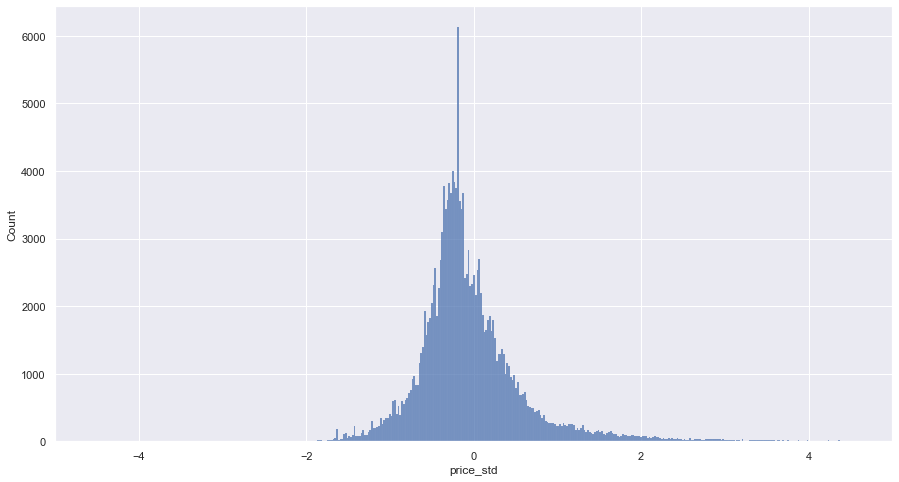

In [22]:
sns.set(rc={"figure.figsize": (15, 8)})

a = sns.histplot(data=token_df, x="price_std")
a.set(xlim=(-5, 5))

## T-Test Analysis

The next step is to loop through the token IDs and determine which ones are trading at a premium at a statistically significant level (p-value of 0.05). Here are some helper functions.

In [24]:
def t_test(x, y, alternative="greater"):
    _, double_p = ttest_ind(x, y, equal_var=False)
    if alternative == "both-sided":
        pval = double_p
    elif alternative == "greater":
        if np.mean(x) > np.mean(y):
            pval = double_p / 2.0
        else:
            pval = 1.0 - double_p / 2.0
    elif alternative == "less":
        if np.mean(x) < np.mean(y):
            pval = double_p / 2.0
        else:
            pval = 1.0 - double_p / 2.0
    return pval


def process_token(token_id, token_df):
    token_sales = token_df[token_df["id"] == token_id]["price_std"].values
    number_of_token_sales = len(token_sales)
    other_sales = (
        token_df[token_df["id"] != token_id]
        .sample(number_of_token_sales)["price_std"]
        .values
    )
    p_val = t_test(token_sales, other_sales)
    return p_val


def process_all_tokens(token_df):
    token_p_values = list()
    token_ids = token_df["id"].unique()
    for token_id in tqdm(token_ids):
        token_p_val = process_token(token_id, token_df)
        if token_p_val <= 0.05:
            token_p_values.append({"id": token_id, "p_val": token_p_val, "sig": 1})
        else:
            token_p_values.append({"id": token_id, "p_val": token_p_val, "sig": 0})
    return pd.DataFrame(token_p_values)

In [25]:
token_p_vals = process_all_tokens(token_df)
token_p_vals

  0%|          | 0/14758 [00:00<?, ?it/s]

,id,p_val,sig
0,1,1.106781e-13,1
1,420,9.835147e-01,0
2,69,1.989310e-02,1
3,1263,1.367420e-01,0
4,5111,1.451790e-01,0
...,...,...,...
14753,10565,NaN,0
14754,10766,NaN,0
14755,10765,NaN,0
14756,10462,NaN,0


## Low Number Sales

Let's first test whether low numbered tokens fetch a premium. Care has been taken to remove collections where low numbered tokens were specifically reserved for 1/1 editions etc but some noise may have crept through. 

In [27]:
low_numbered_sales = token_p_vals[
    (token_p_vals["id"] <= 10) & (token_p_vals["id"] >= 1)
].sort_values(by="id", ascending=True)
low_numbered_sales

,id,p_val,sig
0,1,1.106781e-13,1
2294,2,1.262669e-09,1
2385,3,6.782448e-01,0
1423,4,1.599212e-03,1
6879,5,9.981724e-01,0
9961,6,9.932547e-01,0
2444,7,9.999997e-01,0
6165,8,9.999345e-01,0
6158,9,2.595221e-09,1
7828,10,8.618812e-07,1


We can see above that a handful of the lower numbered tokens are trading at a premium to their peers but it's not really resounding enough to suggest that you'd be confident in bidding for lower numbered tokens as a means of generating alpha.

## Meme Number Sales

Now for the fun part, is there alpha in purchasing meme number tokens? Here we're going to look at 1337, 69 and of course 420.

In [29]:
meme_sales = token_p_vals[token_p_vals["id"].isin([1337, 69, 420])]
meme_sales

,id,p_val,sig
1,420,0.983515,0
2,69,0.019893,1
7821,1337,0.553500,0


So our findings are slightly disappointing, only one meme number is trading at a premium! We might be victims of small samples here too. But it's interesting nonetheless that the number 69 is attracting the interest of NFT investors....

## Experiment Improvements

This experiment was mainly a victim of difficulty in getting historical token sales data. We couldn't use the OpenSea API which would have made things significantly easier than using DappRadar who are very quick to IP ban or rate limit and thus make it really hard to build up large sample sizes. Once I have an OpenSea API key to use I'd like to revisit this analysis and see if the same findings hold true.